# 15 MIN 

In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Embedding, Bidirectional, TimeDistributed, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l2
from tqdm import tqdm
# from keras_tqdm import TQDMNotebookCallback
import tensorflow.keras.backend as K
import os
import time
import pandas as pd
import numpy as np
import psutil
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
tf.debugging.set_log_device_placement(True)
print(tf.__version__)
print(tensorflow.keras.__version__)

2.3.1
2.4.0


In [3]:
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print('Using GPU')
    for gpu in gpu_devices[4:6]:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print('Using CPU')
    tf.config.optimizer.set_jit(True)
    print('used: {}% free: {:.2f}GB'.format(psutil.virtual_memory().percent, float(psutil.virtual_memory().free)/1024**3))#@ 

Using GPU


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use some GPUs
    try:
        tf.config.experimental.set_visible_devices(gpus[4:6], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Visible devices must be set at program startup
        print(e)

8 Physical GPU, 2 Logical GPUs


In [5]:
tf.config.experimental.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU')]

In [6]:
import psutil
print('used: {}% free: {:.2f}GB'.format(psutil.virtual_memory().percent, float(psutil.virtual_memory().free)/1024**3))

used: 3.4% free: 363.19GB


In [7]:
# Prepare News headlines
def clean_text(df, column):
    import re 
    #("".join(headline)).strip()
    headline = []
    for i in df[column].apply(lambda x: '<s>'+x+'<\s>'):
        headline.append(i)
    return headline

#get sequences of equal length to ensure <\s is at the end
def extract_end(char_seq, seq_len):
    if len(char_seq) > seq_len:
        char_seq = char_seq[-seq_len:]
    return char_seq

# Encode to integers by using ascii 128
def encode2bytes(text):
    #text = tf.strings.unicode_split(text, 'UTF-8').to_list()
    final_list = []
    for sent in text:
        temp_list = []
        for char in sent:
            if ord(char) < 128 :
                temp_list.append(ord(char))
        final_list.append(temp_list)
    return final_list

def split_X_y(text):
    X = []
    y = []
    for i in text:
        X.append(i[0:-1])
        y.append(i[1:])
    return X,y

In [8]:
# fix random seed for reproducibility
K.clear_session()
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
idx = pd.IndexSlice
max_length = 250

In [10]:
# Get data
with pd.HDFStore('model_data.h5') as data:
    print(data.keys())
    data = data['model_data/15_min']
    data.headline = data.headline.apply(lambda x: extract_end(x, max_length))
    data['headline'] = data.headline.apply(lambda x: '<s>' + x + '<\s')
    X = data.loc[:,'headline']
    y = data.loc[:, 'label']
    y[y<0] = 0
    print(y.unique())

['/model_data/15_min', '/model_data/daily', '/model_data/hourly']
[1. 0.]


In [11]:
data.head().append(data.tail())

headline  \
ticker time                                                                     
A      2019-07-11 16:30:00  <s>Cleary Gottlieb Steen & Hamilton LLP - Agil...   
       2019-07-11 19:00:00  <s>Fitch Ratings: Agilent Expands Cell Analysi...   
       2019-07-11 19:45:00  <s>NYSE ORDER IMBALANCE <A.N> 149300.0 SHARES ...   
       2019-07-12 14:00:00         <s>BioTek to be sold for $1.165 billion<\s   
       2019-07-12 15:45:00  <s>Agilent to Acquire BioTek, Cell Analysis Po...   
ZTS    2020-10-07 14:30:00  <s>Sachem Head takes $1.2 bln position in Elan...   
       2020-10-09 19:45:00  <s>NYSE ORDER IMBALANCE <ZTS.N> 230640.0 SHARE...   
       2020-10-12 13:30:00  <s>ZOETIS INC <ZTS.N>: BOFA GLOBAL RESEARCH RA...   
       2020-10-12 19:45:00  <s>NYSE ORDER IMBALANCE <ZTS.N> 77562.0 SHARES...   
       2020-10-14 16:45:00  <s>Why Zoetis (ZTS) is Poised to Beat Earnings...   

                            label  
ticker time                        
A      2019-07-11 16:30:00    1.0  
       2019-07-11 19:00:00    0.0  
       2019-07-11 19:45:00    1.0  
       2019-07-12 14:00:00    1.0  
       2019-07-12 15:45:00    0.0  
ZTS    2020-10-07 14:30:00    0.0  
       2020-10-09 19:45:00    1.0  
       2020-10-12 13:30:00    0.0  
       2020-10-12 19:45:00    0.0  
       2020-10-14 16:45:00    0.0

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 184146 entries, ('A', Timestamp('2019-07-11 16:30:00')) to ('ZTS', Timestamp('2020-10-14 16:45:00'))
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   headline  184146 non-null  object 
 1   label     184146 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.9+ MB


In [13]:
data.head().append(data.tail())

headline  \
ticker time                                                                     
A      2019-07-11 16:30:00  <s>Cleary Gottlieb Steen & Hamilton LLP - Agil...   
       2019-07-11 19:00:00  <s>Fitch Ratings: Agilent Expands Cell Analysi...   
       2019-07-11 19:45:00  <s>NYSE ORDER IMBALANCE <A.N> 149300.0 SHARES ...   
       2019-07-12 14:00:00         <s>BioTek to be sold for $1.165 billion<\s   
       2019-07-12 15:45:00  <s>Agilent to Acquire BioTek, Cell Analysis Po...   
ZTS    2020-10-07 14:30:00  <s>Sachem Head takes $1.2 bln position in Elan...   
       2020-10-09 19:45:00  <s>NYSE ORDER IMBALANCE <ZTS.N> 230640.0 SHARE...   
       2020-10-12 13:30:00  <s>ZOETIS INC <ZTS.N>: BOFA GLOBAL RESEARCH RA...   
       2020-10-12 19:45:00  <s>NYSE ORDER IMBALANCE <ZTS.N> 77562.0 SHARES...   
       2020-10-14 16:45:00  <s>Why Zoetis (ZTS) is Poised to Beat Earnings...   

                            label  
ticker time                        
A      2019-07-11 16:30:00    1.0  
       2019-07-11 19:00:00    0.0  
       2019-07-11 19:45:00    1.0  
       2019-07-12 14:00:00    1.0  
       2019-07-12 15:45:00    0.0  
ZTS    2020-10-07 14:30:00    0.0  
       2020-10-09 19:45:00    1.0  
       2020-10-12 13:30:00    0.0  
       2020-10-12 19:45:00    0.0  
       2020-10-14 16:45:00    0.0

In [14]:
X.shape, y.shape

((184146,), (184146,))

In [15]:
# Train / Test / Infer: Test  which is Validation here: 2019-07-08--->2019-08-01, Infer on 
X_train, X_test, X_infer = X.loc[idx[:,'2019-08-01':'2020-10-01'], ], X.loc[idx[:,:'2019-08-01'], ], X.loc[idx[:,'2020-10-01':], ]
y_train, y_test, y_infer = y.loc[idx[:,'2019-08-01':'2020-10-01'], ], y.loc[idx[:,:'2019-08-01'], ], y.loc[idx[:,'2020-10-01':], ]

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_infer.shape, y_infer.shape

((171786,), (9412,), (171786,), (9412,), (3934,), (3934,))

In [17]:
print('y labels:\n', y.value_counts())
print('Train Labels:\n', y_train.value_counts())
print('Test Labels:\n', y_test.value_counts())
print('Inference Labels:\n', y_infer.value_counts())
print("Train Ratio %.2f" % (len(X_train)/ len(X)))

y labels:
 1.0    94247
0.0    89899
Name: label, dtype: int64
Train Labels:
 1.0    88003
0.0    83783
Name: label, dtype: int64
Test Labels:
 0.0    4808
1.0    4604
Name: label, dtype: int64
Inference Labels:
 1.0    2093
0.0    1841
Name: label, dtype: int64
Train Ratio 0.93


In [18]:
# ENCODE ORDINAL
X_train = encode2bytes(X_train)
X_test = encode2bytes(X_test)
X_infer = encode2bytes(X_infer)
# X_encode = encode2bytes(X)

Headlines length: 
Mean 95.55 words (Std 55.12) max 256


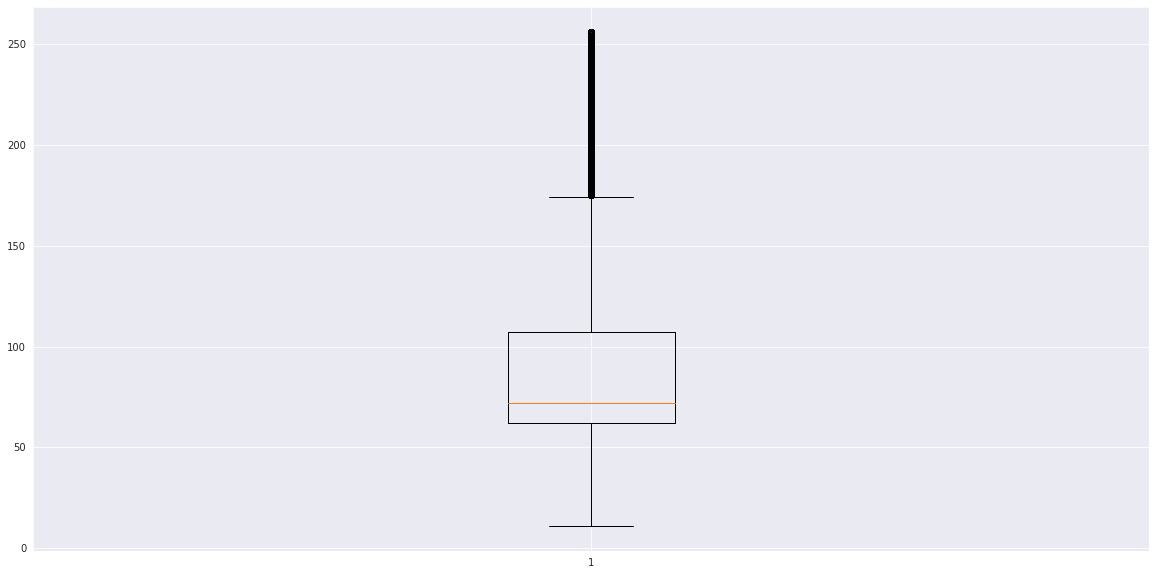

In [19]:
# Summarize headlines length
print("Headlines length: ")
result = [len(sentence) for sentence in X]
print("Mean %.2f words (Std %.2f) max %d" % (np.mean(result), np.std(result), max(result)))
# plot review length
plt.figure(figsize=(20,10));
plt.boxplot(result)
plt.show()

In [20]:
# prepadded to solve for forward propagation not masking
max_sentence_len = max(map(len, X))
X_train = pad_sequences(X_train, maxlen =  max(map(len, X_train)), padding = 'pre', truncating='pre')
X_test = pad_sequences(X_test, maxlen = max(map(len, X_test)), padding = 'pre', truncating='pre')
X_infer = pad_sequences(X_infer, maxlen = max(map(len, X_infer)), padding = 'pre', truncating='pre')
X_train.shape, X_test.shape, X_infer.shape
# X_padded = pad_sequences(X_encode, maxlen = max_sentence_len, padding = 'pre', truncating='pre')

((171786, 256), (9412, 256), (3934, 256))

In [21]:
# Our vectorized labels
train_labels = np.asarray(y_train).astype('float32').reshape((-1,1))
test_labels = np.asarray(y_test).astype('float32').reshape((-1,1))
infer_labels = np.asarray(y_infer).astype('float32').reshape((-1,1))
train_labels.shape, test_labels.shape, infer_labels.shape

((171786, 1), (9412, 1), (3934, 1))

In [22]:
train_seq_data = tf.data.Dataset.from_tensor_slices((X_train,train_labels))
test_seq_data = tf.data.Dataset.from_tensor_slices((X_test,test_labels))
infer_seq_data = tf.data.Dataset.from_tensor_slices((X_infer,infer_labels))

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
batch_size = 128

train_seq_data = train_seq_data.batch(batch_size, drop_remainder=True)
test_seq_data = test_seq_data.batch(batch_size, drop_remainder=True)
infer_seq_data = infer_seq_data.batch(64, drop_remainder=True)
print('Train Set Shape: ', train_seq_data, '\nTest Set Shape: ', test_seq_data)

Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Train Set Shape:  <BatchDataset shapes: ((128, 256), (128, 1)), types: (tf.int32, tf.float32)> 
Test Set Shape:  <BatchDataset shapes: ((128, 256), (128, 1)), types: (tf.int32, tf.float32)>


In [25]:
# with tf.device('CPU'):
train_seq_data = configure_dataset(train_seq_data)
test_seq_data = configure_dataset(test_seq_data)
infer_seq_data = configure_dataset(infer_seq_data)

Executing op DummyMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DummyMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DummyMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [26]:
train_seq_data, test_seq_data, infer_seq_data

(<PrefetchDataset shapes: ((128, 256), (128, 1)), types: (tf.int32, tf.float32)>,
 <PrefetchDataset shapes: ((128, 256), (128, 1)), types: (tf.int32, tf.float32)>,
 <PrefetchDataset shapes: ((64, 256), (64, 1)), types: (tf.int32, tf.float32)>)

In [27]:
# def create_language_model(batch_size):
#     model = Sequential(name = 'CharLSTM')
#     model.add(Embedding(127, 256,batch_input_shape=[batch_size, None], 
#                         mask_zero=True, name ='EmbedLayer'))
#     model.add(Bidirectional(LSTM(1024, return_sequences=True,stateful=False,
#                                  recurrent_initializer='glorot_uniform'), merge_mode ='ave',name = 'BiLSTM'))
#     model.add(TimeDistributed(Dense(127, name = 'TimeDistDense')))
#     model.compile(optimizer=tf.optimizers.SGD(learning_rate=1e-1), 
#                   loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True))
#     return model
# #Compile then load weights
# checkpoint_dir = './training_checkpoints_CharWeights2/ckpt_18'

# ChaRmodel = create_language_model(batch_size=None)

# print(tf.train.latest_checkpoint(checkpoint_dir))
# ChaRmodel.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

# ChaRmodel.build(tf.TensorShape([1,None]))

# # Get layers to intialize classification model
# embeddings = ChaRmodel.layers[0].get_weights()[0]
# lstm = ChaRmodel.layers[1].get_weights()[0]
# print(embeddings.shape, lstm.shape)

ChaRmodel = tf.keras.models.load_model('CharLM.h5')
ChaRmodel.summary()

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalN

In [28]:
def direction_model():
    model = Sequential(name = 'RNNStocks')
    model.add(Embedding(input_dim = 127, output_dim = 256,batch_input_shape=[None, None],
                        mask_zero = True, name ='EmbedLayer'))
    model.add(Bidirectional(LSTM(1024,
                                 return_sequences=False,stateful=False, 
                                 recurrent_initializer='glorot_uniform'), merge_mode ='concat',name = 'BiLSTM'))
    #final state encodes full representation of a single passed headine
    model.add(BatchNormalization(name='BatchNormal')) #After RNN(S-shape activation-f(x) / Before ReLU(Non-Gaussian))
    model.add(tf.keras.layers.Masking(mask_value=0))
    model.add(Dense(512, name = 'FullConnected')) 
    model.add(tf.keras.layers.LeakyReLU()) #controls vanishing gradients:f(x) =  a * (exp(x) - 1.) for x < 0 ; f(x) = x for x >= 0
    #model.add(BatchNormalization(name='BatchNormal2'))
    model.add(Dense(1, activation='sigmoid',name='Output'))
    model.compile(optimizer=tf.optimizers.Adadelta(learning_rate = 1e-03, clipnorm = 5), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy',  tf.keras.metrics.AUC(name='AUC')])
    return model

In [29]:
previous_training = tf.keras.models.load_model('15_mins.h5').get_weights()

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalN

In [30]:
 # batch size of 128 headlines is used to space out weight updates for our large data
epochs = 100
# # with strategy.scope():
# gpus = tf.config.experimental.list_logical_devices('GPU')
# if gpus:
#   # Replicate your computation on multiple GPUs
#   for gpu in gpus:
with tf.device('GPU:1'):
#     with  tf.device('GPU:3'):
    model = direction_model()
    checkpoint_dir = './training_checkpoints_CharWeights'
    # print(tf.train.latest_checkpoint(checkpoint_dir))
    # model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    model.layers[0].set_weights(ChaRmodel.layers[0].get_weights())
    model.layers[1].set_weights(ChaRmodel.layers[1].get_weights())

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op LogicalN

In [31]:
model.summary()

Model: "RNNStocks"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EmbedLayer (Embedding)       (None, None, 256)         32512     
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 2048)              10493952  
_________________________________________________________________
BatchNormal (BatchNormalizat (None, 2048)              8192      
_________________________________________________________________
masking (Masking)            (None, 2048)              0         
_________________________________________________________________
FullConnected (Dense)        (None, 512)               1049088   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 1)                 51

In [32]:
print(np.all(model.get_layer('EmbedLayer').get_weights()[0] == ChaRmodel.get_layer('EmbedLayer').get_weights()[0] ))
for i in range(0, len(model.get_layer('BiLSTM').get_weights())):
    print(np.all(model.get_layer('BiLSTM').get_weights()[i] == ChaRmodel.get_layer('BiLSTM').get_weights()[i]))

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
True
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in devi

In [33]:
print([layer.supports_masking for layer in model.layers])
print([layer.supports_masking for layer in ChaRmodel.layers])

[True, True, True, True, True, True, True]
[True, True, True]


In [34]:
# Name of the checkpoint files and save each weights at each epoch
# checkpoint_dir = './training_Daily'
# checkpoint_prefix = os.path.join(checkpoint_dir, "daily.h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                               filepath='15_mins.h5',
                               verbose=1,
                               monitor='val_AUC',
                               mode='max',
                               save_best_only=True)

# early_stopping = EarlyStopping(monitor='val_AUC',
#                                patience=10,
#                                mode='max',
#                                restore_best_weights=True)


### Test Model Pre training it

In [35]:
sample = 'MSFT rallying after last earnings call' 
sample = '<s>' + sample + '<\s' 
print(sample)
sample = encode2bytes(sample)
print(sample)
sample = tf.squeeze(sample)
sample = tf.expand_dims(sample, 0).numpy()
sample.shape

<s>MSFT rallying after last earnings call<\s
[[60], [115], [62], [77], [83], [70], [84], [32], [114], [97], [108], [108], [121], [105], [110], [103], [32], [97], [102], [116], [101], [114], [32], [108], [97], [115], [116], [32], [101], [97], [114], [110], [105], [110], [103], [115], [32], [99], [97], [108], [108], [60], [92], [115]]
Executing op Squeeze in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:GPU:0


(1, 44)

In [36]:
padded_sample = 'MSFT rallying after last earnings call' 
padded_sample = '<s>' + padded_sample + '<\s' + chr(0) * 20
print(padded_sample)
padded_sample = encode2bytes(padded_sample)
print(padded_sample)
padded_sample = tf.squeeze(padded_sample)
padded_sample = tf.expand_dims(padded_sample, 0).numpy()
padded_sample.shape

<s>MSFT rallying after last earnings call<\s                    
[[60], [115], [62], [77], [83], [70], [84], [32], [114], [97], [108], [108], [121], [105], [110], [103], [32], [97], [102], [116], [101], [114], [32], [108], [97], [115], [116], [32], [101], [97], [114], [110], [105], [110], [103], [115], [32], [99], [97], [108], [108], [60], [92], [115], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
Executing op Squeeze in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:GPU:0


(1, 64)

In [37]:
print(model(sample).numpy())
print('vs')
print(model(padded_sample).numpy())

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ResourceGather in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NotEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GP

In [38]:
1/(1+np.exp(-0.53))

0.6294831119673949

In [ ]:
start = time.time()
history = model.fit(train_seq_data, epochs=epochs,
                    verbose = 1, validation_data=(test_seq_data),
                    callbacks=[checkpoint_callback])
end = time.time()
print("Time took {:3.1f} min".format((end-start)/60))

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

In [47]:
score = model.evaluate((test_seq_data), verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test AUC:', score[2])

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executin

In [48]:
score = model.evaluate((infer_seq_data), verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test AUC:', score[2])

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executin

In [51]:
df = pd.DataFrame(history.history)
df.index +=1

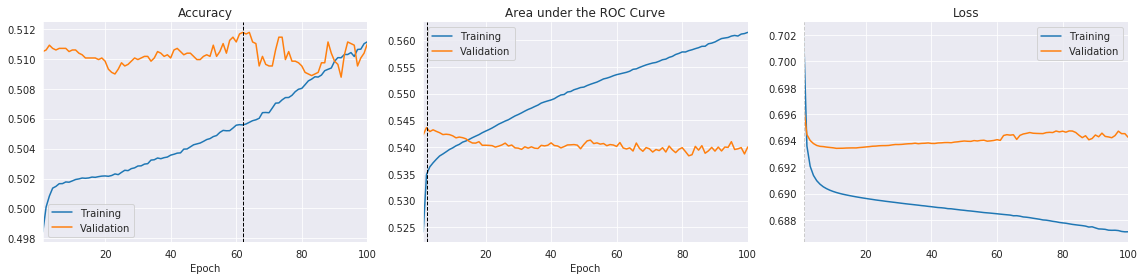

In [52]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
#ACCURACY
df1 = (df[['accuracy', 'val_accuracy']]
       .rename(columns={'accuracy': 'Training',
                        'val_accuracy': 'Validation'}))
df1.plot(ax=axes[0], title='Accuracy', xlim=(1, len(df)))

axes[0].axvline(df.val_accuracy.idxmax(), ls='--', lw=1, c='k')
#AUC
df2 = (df[['AUC', 'val_AUC']]
       .rename(columns={'AUC': 'Training',
                        'val_AUC': 'Validation'}))
df2.plot(ax=axes[1], title='Area under the ROC Curve', xlim=(1, len(df)))

axes[1].axvline(df.val_AUC.idxmax(), ls='--', lw=1, c='k')
#LOSS
df2 = (df[['loss', 'val_loss']]
       .rename(columns={'loss': 'Training',
                        'val_loss': 'Validation'}))
df2.plot(ax=axes[2], title='Loss', xlim=(1, len(df)))

axes[2].axvline(df.val_loss.idxmax(), ls='--', lw=1, c='k')
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

sns.despine()
fig.tight_layout()

In [ ]:
# term = "<s>MSFT rallying after last earnings call <\s" + chr(0) * 20
# input_val = [ord(s) for s in term] 
# print(term)
# print(input_val)
# term = tf.expand_dims(input_val, 0)
# pred = ChaRmodel.predict(term.numpy())
# pred = tf.squeeze(pred, 0)
# print("".join(map(chr,np.argmax(pred, axis = 1))))

In [ ]:
# padded_sample = 'MSFT rallying after last earnings call' 
# padded_sample = '<s>' + padded_sample + '<\s' #+ chr(0) * 20
# print(padded_sample)
# padded_sample = encode2bytes(padded_sample)
# print(padded_sample)
# padded_sample = tf.squeeze(padded_sample)
# padded_sample = tf.expand_dims(padded_sample, 0).numpy()
# padded_sample.shape

In [ ]:
# print(model(padded_sample).numpy())